In [1]:
#packages import
import os
os.chdir('..') #cd to PiperNET folder

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

#matplotlib settings
plt.style.use('classic')
plt.rcParams['figure.facecolor'] = 'white'

### Data import

In [2]:
from src.import_utils import get_config
from src.import_utils import import_sonicpd

config_path = Path('config/rnaseq_dataprep.yaml')
proteomes_all = pd.read_csv('data/rna-seq/proteomes_all.csv', index_col='id') #merged proteome file
sonicpd = import_sonicpd(get_config(config_path, data='orthogroups', file='sonicparanoid'))
blastDBs = get_config(Path('config/rnaseq_dataprep.yaml'), data='blastDB') #BLAST databases paths
enzymeDB = pd.read_csv('data/rna-seq/enzymeDB.csv')
seq_paths = get_config(config_path, data='enzymeDB') #sequences paths
prefixes = get_config(config_path, data='prefix', filepaths=False)
species_names = get_config(config_path, data='species', filepaths=False)
legend = get_config(config_path, data='colors', filepaths=False) #colors legend

### BLASTp P. nigrum sequences
BLASTp all characterized enzymes in the piperine biosynthetic pathway against all transcriptomes:
- PnBAHD1 (BAHD acyltransferase)
- PnBAHD2 (BAHD acyltransferase)
- PnCYP719A37 (CYP450)
- PnPIPCoAL (Piperic acid-CoA-ligase)
- PnFDS1 (Feruloyldiketide-CoA synthases)
- PnFDS2 (Feruloyldiketide-CoA synthases)
- PnLDC (Lysine decarboxylase)
- PnCAO (Copper amine oxidase) 

In [3]:
from src.rnaseq_utils import run_blastp
pn_queries = {k: v for k, v in seq_paths.items() if 'Pn' in k} #keep only Pn sequences

#BLASTp all seqs vs all proteomes
out = Path('results/blast/pn_hits.csv')
if not os.path.isfile(out):

    #BLASTp pn_queries vs all proteomes
    hits_all = run_blastp(pn_queries, blastDBs, out_path=out, min_cov=50, min_sim=50, min_bitscore = 50, create_combinedID = False)

else:
    print(f"File {out} already exists. Importing existing file.")
    hits_all = pd.read_csv(out)

File results/blast/pn_hits.csv already exists. Importing existing file.


### Evaluate P. nigrum hits
Best hits (based on similarity) against P. nigrum transcriptome (piper56) are retained

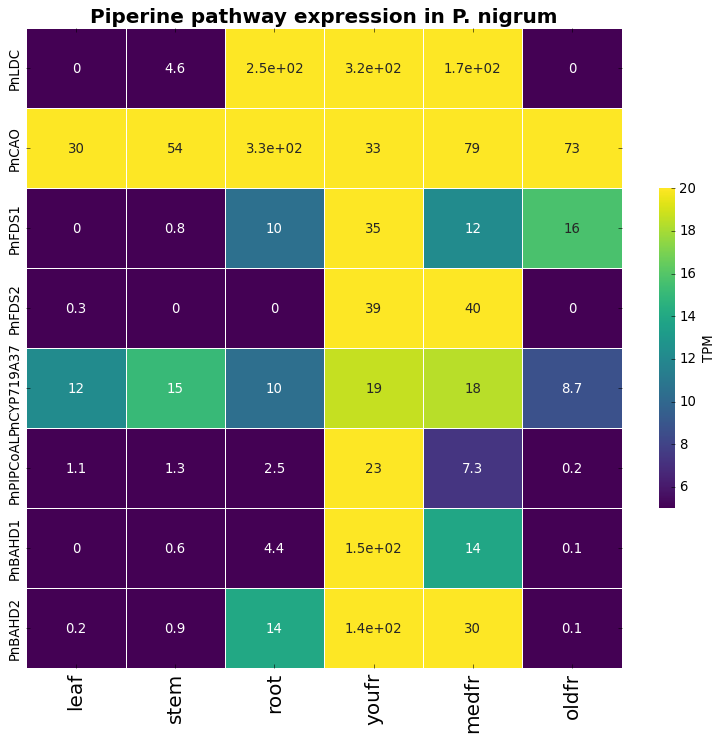

In [53]:
hits_p56 = hits_all[hits_all['sample'] == 'piper56'].sort_values(by='similarity', ascending=False).groupby('query').first() #keep P. nigrum best hits
hits_p56_ids = hits_p56['hit']

from src.rnaseq_utils import assign_tissue_expr
data = assign_tissue_expr(proteomes_all.loc[hits_p56_ids], metric='mean')

#switch index in data with hits_p56.index
if (data.index == hits_p56['hit']).all(): #check if the id match
    data.index = hits_p56.index
    enzyme_order = ['PnLDC', 'PnCAO', 'PnFDS1', 'PnFDS2', 'PnCYP719A37', 'PnPIPCoAL', 'PnBAHD1', 'PnBAHD2']
    data = data.reindex(enzyme_order)

#plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(data, cmap='viridis', annot=True, yticklabels=True, vmin=5, vmax=20,
            linewidths=0.5,
            cbar_kws={'label': 'TPM', 'orientation': 'vertical', 'pad': 0.05, 'shrink': 0.5})
plt.yticks(fontsize=12, rotation=90)
plt.xticks(fontsize=18, rotation=90)
plt.ylabel('')
plt.title('Piperine pathway expression in P. nigrum', fontdict={'fontsize': 18, 'fontweight': 'bold'})
plt.show()

# FROM HERE
- Use entry size to display another parameter

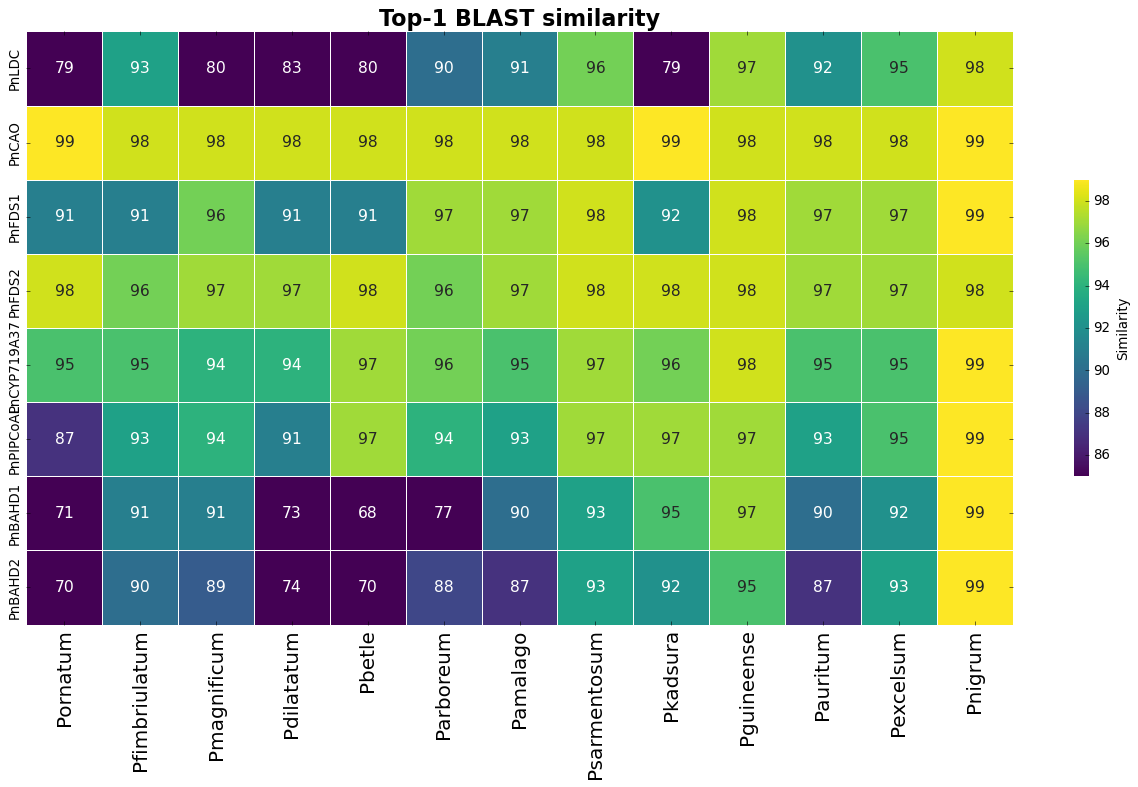

In [115]:
sim_matrix = hits_all.sort_values('similarity', ascending=False).groupby(['sample','query']).first() #keep best hit (similarity) for each query
sim_matrix = sim_matrix.reset_index().pivot(index='query', columns='sample', values='similarity').astype(int)
sim_matrix = sim_matrix.rename(columns=species_names).reindex(enzyme_order)

#plot heatmap
plt.figure(figsize=(16, 10))  # adjust the size of the plot as needed
sns.heatmap(sim_matrix.astype(float), cmap='viridis', vmin=85, annot=True, annot_kws={"fontsize":14},
            linewidths=0.5,
            cbar_kws={'label': 'Similarity', 'orientation': 'vertical', 'pad': 0.05, 'shrink': 0.5})
#sns.clustermap(matrix.astype(float), annot=annotations, fmt="", cmap='YlGnBu', annot_kws={"fontsize": annot_font})
plt.yticks(fontsize=12, rotation=90)
plt.xticks(fontsize=18, rotation=90)
plt.xlabel('')
plt.ylabel('')
plt.title('Top-1 BLAST similarity', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

In [124]:
#use sim_matrix as template to create coverage and e-value matrices
sim_matrix = hits_all.sort_values('similarity', ascending=False).groupby(['sample','query']).first() #keep best hit (similarity) for each query
coverage_matrix = sim_matrix.reset_index().pivot(index='query', columns='sample', values='query coverage').astype(int)
eval_matrix = sim_matrix.reset_index().pivot(index='query', columns='sample', values='e-value')
eval_matrix

sample,piper06,piper09,piper10,piper12,piper20,piper23,piper25,piper26,piper27,piper32,piper54,piper55,piper56
query,,,,,,,,,,,,,
PnBAHD1,5.580000e-149,0.0,0.0,1.200000e-178,3.680000e-162,3.100000e-123,1.670000e-145,0.0,0.000000e+00,0.0,0.0,0.0,0.0
PnBAHD2,1.230000e-149,0.0,0.0,2.820000e-126,1.490000e-167,0.000000e+00,0.000000e+00,0.0,6.710000e-158,0.0,0.0,0.0,0.0
PnCAO,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0
PnCYP719A37,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0
PnFDS1,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0
PnFDS2,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0
PnLDC,1.330000e-157,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0
PnPIPCoAL,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0


# DSICARD CODE BELOW AFTER DONE ABOVE

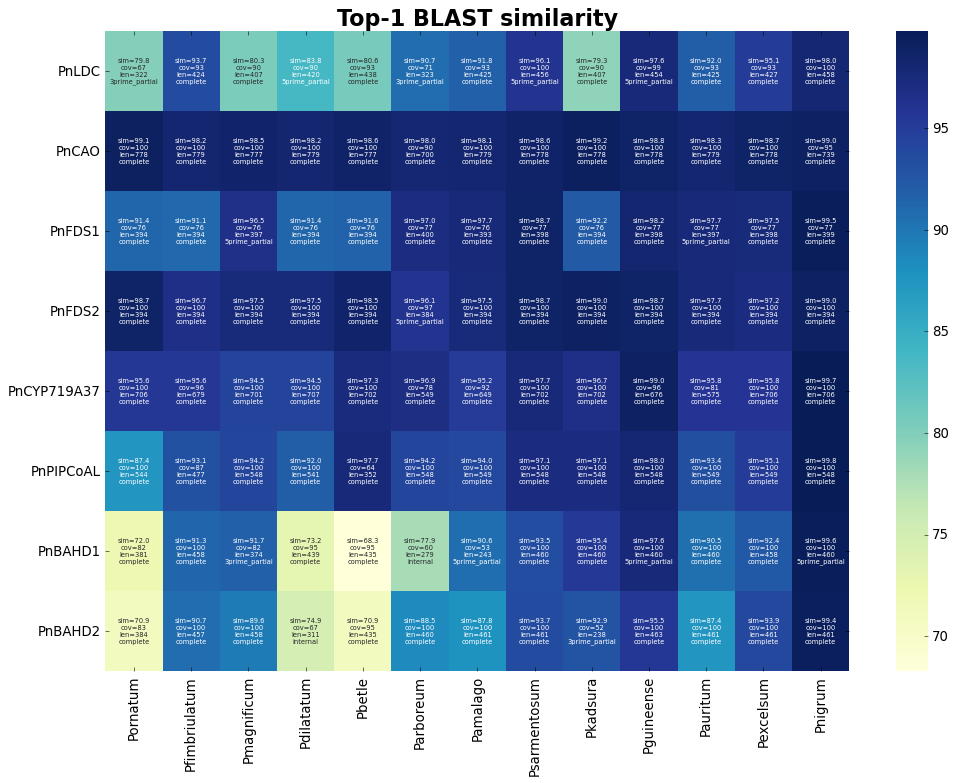

In [58]:
#create sequences-vs-sample matrix
matrix = pd.DataFrame(index=pn_queries.keys(), columns=species_names.keys()).reindex(enzyme_order)
annotations = pd.DataFrame(index=pn_queries.keys(), columns=species_names.keys()).reindex(enzyme_order)

full_annotation = True #if True, heatmap displays similarity, coverage, length, ORF type
annot_font = 6 #heatmpap text size

#fill each entry with similarity of top BLAST hit
for index in matrix.index:
    for column in matrix.columns:
        hits_filt = hits_all.loc[(hits_all['query'] == index) & (hits_all['sample'] == column)].sort_values(by='similarity', ascending=False)
        if not hits_filt.empty:
            top_hit = hits_filt.iloc[0] #keep top hit (based on similarity)
            top_sim = top_hit['similarity'].round(1)
            top_len = len(top_hit['hit sequence'].replace('-', ''))
            top_cov = top_hit['query coverage'].round(1)
            top_orf = proteomes_all.loc[top_hit['hit']]['orf_type']
            matrix.at[index, column] = top_sim
            if full_annotation==True:
                annotations.at[index, column] = ('sim='+str(top_sim)) + '\n' + ('cov='+str(top_cov)) + '\n' + ('len='+str(top_len)) + '\n' + (str(top_orf))
            else:
                annotations.at[index, column] = top_cov

#plot heatmap
matrix.rename(columns=species_names, inplace=True)
plt.figure(figsize=(15, 10))  # adjust the size of the plot as needed
sns.heatmap(matrix.astype(float), annot=annotations, fmt="", cmap='YlGnBu', annot_kws={"fontsize": annot_font})

# #clustermap
# sns.clustermap(matrix.astype(float), annot=annotations, fmt="", cmap='YlGnBu', annot_kws={"fontsize": annot_font})

plt.title('Top-1 BLAST similarity', fontsize=20, fontweight='bold')
plt.show()

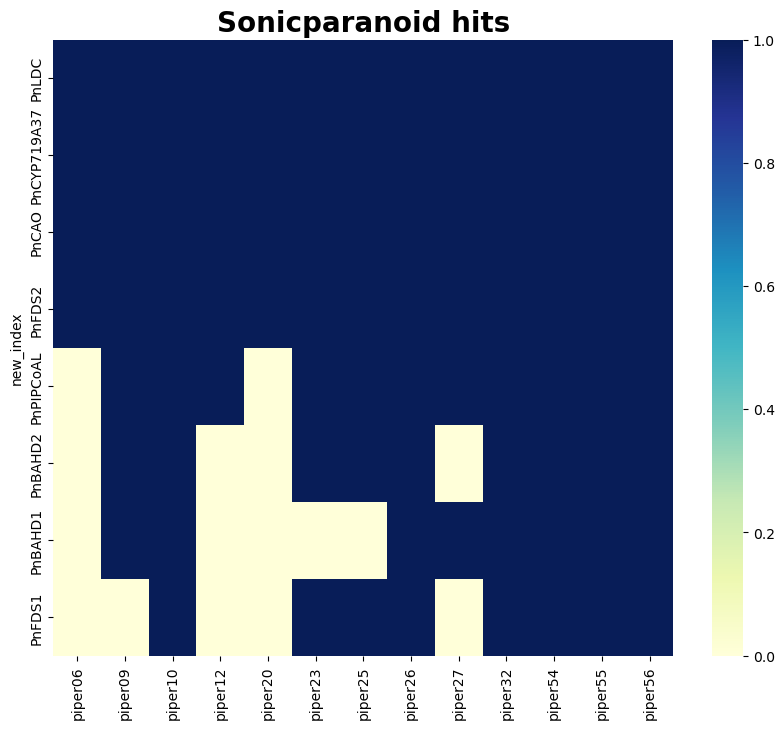

In [99]:
#piper56 best  hit per query
hits_p56 = hits_all[hits_all['sample'] == 'piper56'].sort_values(by='similarity', ascending=False).groupby('query').first()
hits_p56 = hits_p56['hit']

#Filter rows in sonicpd where any element in 'piper56' column is in hits_p56['hit'].values
filtered_sonicpd = sonicpd[sonicpd['piper56'].apply(lambda x: any(i in hits_p56.values for i in x))].copy()

# Create a mapping from the values in hits_p56 to their index
index_mapping = hits_p56.reset_index().set_index('hit')['query']

# Use the mapping to set the index in filtered_sonicpd
filtered_sonicpd['new_index'] = filtered_sonicpd['piper56'].apply(lambda x: [index_mapping[i] for i in x if i in index_mapping])
filtered_sonicpd = filtered_sonicpd.explode('new_index').reset_index(drop=True).set_index('new_index')

filtered_sonicpd = filtered_sonicpd[[col for col in filtered_sonicpd.columns if 'piper' in col]]
filtered_sonicpd

#replace entries with list lenght
filtered_sonicpd = filtered_sonicpd.applymap(lambda x: len(x))


#replace entries with presence/absence
filtered_sonicpd = filtered_sonicpd.applymap(lambda x: 1 if x > 0 else 0)
filtered_sonicpd

#display filtered_sonicpd as heatmap
plt.figure(figsize=(10, 8))  # adjust the size of the plot as needed
sns.heatmap(filtered_sonicpd.astype(float), cmap='YlGnBu')
plt.title('Sonicparanoid hits', fontsize=20, fontweight='bold')
plt.show()